In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
from torch.autograd import Variable
import numpy as np

import shutil
from easydict import EasyDict as edict
from dataset_preprocessor import Human
from Losses import FocalLoss
from PotraitNet import PotraitNet
import os
import warnings
warnings.filterwarnings("ignore", category=UserWarning)


In [2]:
args = edict()
args.batchsize = 32 #64
args.lr = 0.001
args.momentum = 0.9
args.weightdecay = 5e-4
args.printfreq = 100
args.savefreq = 1000
args.workers = 2
args.model_root = "data\model\\"
args.input_height = args.input_width = 224

# the probability to set empty prior channel, default=0.5
args.prior_prob = 0.5

# the weight of boundary auxiliary loss, default=0.1
args.edgeRatio = 0.1

# temperature in consistency constraint loss, default=1
args.temperature = 1

# the weight of consistency constraint loss, default=2
args.alpha = 2

# input normalization parameters
args.padding_color = 128
args.img_scale = 1
# BGR order
args.img_mean = [103.94, 116.78, 123.68]
args.img_val = [0.017, 0.017, 0.017]

args.resume_train = True

Compute the train dataset

In [3]:
args.istrain = False
dataset_train = Human(args)
print ("image number in training: ", len(dataset_train))
dataLoader_train = torch.utils.data.DataLoader(dataset_train, batch_size=args.batchsize, 
                                                   shuffle=True, num_workers= args.workers)

image number in training:  289


Compute the Test Dataset

In [4]:
args.istrain = False
dataset_test = Human(args)
print ("image number in testing: ", len(dataset_test))
dataLoader_test = torch.utils.data.DataLoader(dataset_test, batch_size=1, 
                                                  shuffle=False, num_workers=args.workers)

image number in testing:  289


import the model

In [5]:
netmodel = PotraitNet(channelRatio=1.0, 
                      minChannel=16, 
                      weightInit=True).cuda()

In [6]:
def get_parameters(model, args):
    lr_0 = []
    lr_1 = []
    params_dict = dict(model.named_parameters())
    for key, value in params_dict.items():
        if 'deconv' in key:
            print ("useDeconvGroup=True, lr=0, key: ", key)
            lr_0.append(value)
        else:
            lr_1.append(value)
    params = [{'params': lr_0, 'lr': args.lr * 0},
              {'params': lr_1, 'lr': args.lr * 1}]
    return params, [0., 1.]

params, multiple = get_parameters(netmodel, args)
optimizer = torch.optim.Adam(params, args.lr, weight_decay=args.weightdecay) 

useDeconvGroup=True, lr=0, key:  deconv1.weight
useDeconvGroup=True, lr=0, key:  deconv2.weight
useDeconvGroup=True, lr=0, key:  deconv3.weight
useDeconvGroup=True, lr=0, key:  deconv4.weight
useDeconvGroup=True, lr=0, key:  deconv5.weight


In [7]:
def save_checkpoint(state, is_best, root, filename='checkpoint.pth.tar'):
    torch.save(state, root+filename)
    if is_best:
        shutil.copyfile(root+filename, root+'model_best.pth.tar')

In [8]:
def adjust_learning_rate(optimizer, epoch, args, multiple):
    """Sets the learning rate to the initial LR decayed by 0.95 every 20 epochs"""
    # lr = args.lr * (0.95 ** (epoch // 4))
    lr = args.lr * (0.95 ** (epoch // 20))
    for i, param_group in enumerate(optimizer.param_groups):
        param_group['lr'] = lr * multiple[i]
    pass

In [9]:
def loss_KL(student_outputs, teacher_outputs, T):
    """
    Code referenced from: 
    https://github.com/peterliht/knowledge-distillation-pytorch/blob/master/model/net.py
    
    Compute the knowledge-distillation (KD) loss given outputs, labels.
    "Hyperparameters": temperature and alpha
    NOTE: the KL Divergence for PyTorch comparing the softmaxs of teacher
    and student expects the input tensor to be log probabilities! See Issue #2
    """
    KD_loss = nn.KLDivLoss()(F.log_softmax(student_outputs/T, dim=1), 
                             F.softmax(teacher_outputs/T, dim=1)) * T * T
    return KD_loss

In [10]:
def train(dataLoader, netmodel, optimizer, epoch, exp_args):
    netmodel.train() # switch to train mode
    
    loss_Softmax = nn.CrossEntropyLoss(ignore_index=255) # mask loss
    # in our experiments, focalloss is better than l2 loss
    loss_Focalloss = FocalLoss(gamma=2) # boundary loss
    
    for i, (input_ori, input, edge, mask) in enumerate(dataLoader):  
        input_ori_var = Variable(input_ori.cuda())
        input_var = Variable(input.cuda())
        edge_var = Variable(edge.cuda())
        mask_var = Variable(mask.cuda())

        output_mask, output_edge = netmodel(input_var)
        loss_mask = loss_Softmax(output_mask, mask_var)
        
        loss_edge = loss_Focalloss(output_edge, edge_var) * exp_args.edgeRatio
        
        # total loss
        loss = loss_mask + loss_edge
        
        output_mask_ori, output_edge_ori = netmodel(input_ori_var)
        loss_mask_ori = loss_Softmax(output_mask_ori, mask_var)
        
        # consistency constraint loss: KL distance (better than L2 distance)
        loss_stability_mask = loss_KL(output_mask, 
                                        Variable(output_mask_ori.data, requires_grad = False), 
                                        exp_args.temperature) * exp_args.alpha
        loss_stability_edge = loss_KL(output_edge, 
                                        Variable(output_edge_ori.data, requires_grad = False), 
                                        exp_args.temperature) * exp_args.alpha * exp_args.edgeRatio
        
        # total loss
        # loss = loss_mask + loss_mask_ori + loss_edge + loss_edge_ori + loss_stability_mask + loss_stability_edge
        loss = loss_mask + loss_mask_ori + loss_stability_mask + loss_edge
            
        # compute gradient and do Adam step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if i == len(dataLoader) - 1:
            print(f"Epoch {epoch}:\t Lr-other: {optimizer.param_groups[1]['lr']}\t loss: {loss.data}") 
            
    pass


In [1]:
def calcIOU(img, mask):
    sum1 = img + mask
    sum1[sum1>0] = 1
    sum2 = img + mask
    sum2[sum2<2] = 0
    sum2[sum2>=2] = 1
    if np.sum(sum1) == 0:
        return 1
    else:
        return 1.0*np.sum(sum2)/np.sum(sum1)

In [11]:
def test(dataLoader, netmodel, optimizer, epoch, exp_args):
    # switch to eval mode
    netmodel.eval()
    
    loss_Softmax = nn.CrossEntropyLoss(ignore_index=255) # mask loss
    loss_Focalloss = FocalLoss(gamma=2) # edge loss
    
    softmax = nn.Softmax(dim=1)
    iou = 0
    
    for i, (input_ori, input, edge, mask) in enumerate(dataLoader):  
        input_ori_var = Variable(input_ori.cuda())
        input_var = Variable(input.cuda())
        edge_var = Variable(edge.cuda())
        mask_var = Variable(mask.cuda())
        
        output_mask, output_edge = netmodel(input_var)
        loss_mask = loss_Softmax(output_mask, mask_var)

        loss_edge = loss_Focalloss(output_edge, edge_var) * exp_args.edgeRatio
        loss = loss_mask + loss_edge
        
        output_mask_ori, output_edge_ori = netmodel(input_ori_var)
        loss_mask_ori = loss_Softmax(output_mask_ori, mask_var)
        loss_edge_ori = loss_Focalloss(output_edge_ori, edge_var) * exp_args.edgeRatio
        
        # consistency constraint loss: KL distance
        loss_stability_mask = loss_KL(output_mask, 
                                        Variable(output_mask_ori.data, requires_grad = False), 
                                        exp_args.temperature) * exp_args.alpha
        loss_stability_edge = loss_KL(output_edge, 
                                        Variable(output_edge_ori.data, requires_grad = False), 
                                        exp_args.temperature) * exp_args.alpha * exp_args.edgeRatio
                
        # total loss
        # loss = loss_mask + loss_mask_ori + loss_edge + loss_edge_ori + loss_stability_mask + loss_stability_edge
        loss = loss_mask + loss_mask_ori + loss_stability_mask + loss_edge
        
        prob = softmax(output_mask)[0,1,:,:]
        pred = prob.data.cpu().numpy()
        pred[pred>0.5] = 1
        pred[pred<=0.5] = 0
        iou += calcIOU(pred, mask_var[0].data.cpu().numpy())
        
        """if i % args.printfreq == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
                  'Lr-deconv: [{3}]\t'
                  'Lr-other: [{4}]\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'.format(
                      epoch, i, len(dataLoader), 
                      optimizer.param_groups[0]['lr'],
                      optimizer.param_groups[1]['lr'], 
                      loss=losses)) 
 
            num = 2
            input_mask = mask.cpu().numpy()[0:num]
            input_mask[input_mask==255] = 0
            softmax = nn.Softmax(dim=1)
            prob = softmax(output_mask)
            masks_pred = np.transpose(prob.data.cpu().numpy()[0:num], (0, 2, 3, 1))[:,:,:,1]
                
            print (np.max(masks_pred), np.min(masks_pred))"""
            
    return 1-iou/len(dataLoader)


In [12]:
minLoss = 10000
gap = 0
if args.resume_train:
    bestModelFile = os.path.join(args.model_root, 'model_best.pth.tar')
    if os.path.isfile(bestModelFile):
        checkpoint = torch.load(bestModelFile)
        netmodel.load_state_dict(checkpoint['state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        gap = checkpoint['epoch']
        minLoss = checkpoint['minLoss']
        print("=> loaded checkpoint '{}' (epoch {})".format(bestModelFile, checkpoint['epoch']))
    else:
        print("=> no checkpoint found at '{}'".format(bestModelFile))


=> loaded checkpoint 'data\model\model_best.pth.tar' (epoch 99)


In [48]:
for epoch in range(gap, 10):
    adjust_learning_rate(optimizer, epoch, args, multiple)
    
    train(dataLoader_train, netmodel, optimizer, epoch, args)
    
    # computing the loss on test set to verify if we need to 
    loss = test(dataLoader_test, netmodel, optimizer, epoch, args)
    print (f"epoch {epoch} loss: {loss}, minimum epochs loss: {minLoss}")

    # saving the progress
    is_best = loss < minLoss
    minLoss = loss if is_best else minLoss
    save_checkpoint({
        'epoch': epoch+1,
        'minLoss': minLoss,
        'state_dict': netmodel.state_dict(),
        'optimizer' : optimizer.state_dict(),
        }, is_best, args.model_root)
    

Epoch: [0][0/10]	 Lr-deconv: [0.0]	                   Lr-other: [0.001]	 (1.4156577587127686)	
avg pred: 0.5017126798629761 max pred: 0.7968189120292664 min pred: 0.22534474730491638
loss: 0.8886397210035096, minLoss: 10000
Epoch: [1][0/10]	 Lr-deconv: [0.0]	                   Lr-other: [0.001]	 (1.3310667276382446)	
avg pred: 0.4988054931163788 max pred: 0.7261040806770325 min pred: 0.3185040354728699


RuntimeError: Caught MemoryError in DataLoader worker process 1.
Original Traceback (most recent call last):
  File "c:\Users\leona\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\data\_utils\worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)
  File "c:\Users\leona\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\data\_utils\fetch.py", line 51, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "c:\Users\leona\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\data\_utils\fetch.py", line 51, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "c:\Users\leona\Documents\projects\Computer_Vision_CIE6004_CUHKsz\PotraitNet\dataset_preprocessor.py", line 40, in __getitem__
    input_ori, input, output_edge, output_mask = self.datasets[subset][subsetidx]
  File "c:\Users\leona\Documents\projects\Computer_Vision_CIE6004_CUHKsz\PotraitNet\dataset_preprocessor.py", line 101, in __getitem__
    img_aug_ori, mask_aug_ori = padding(img, mask, size=self.input_width, padding_color=self.padding_color)
  File "c:\Users\leona\Documents\projects\Computer_Vision_CIE6004_CUHKsz\PotraitNet\data_aug.py", line 172, in padding
    img = np.zeros((max(height, width), max(height, width), 3)) + padding_color
numpy.core._exceptions._ArrayMemoryError: Unable to allocate 14.6 MiB for an array with shape (800, 800, 3) and data type float64


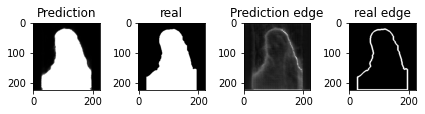

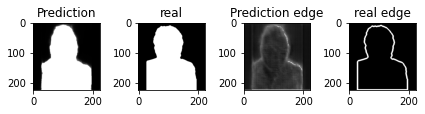

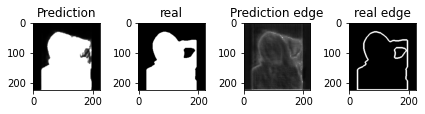

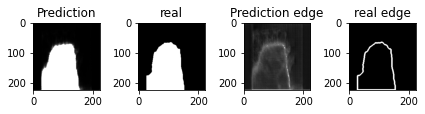

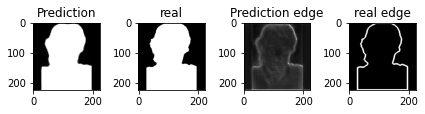

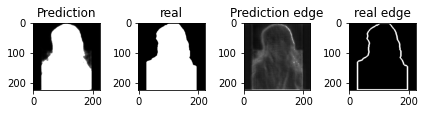

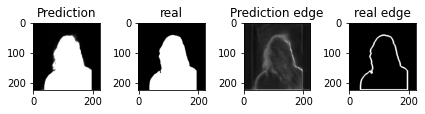

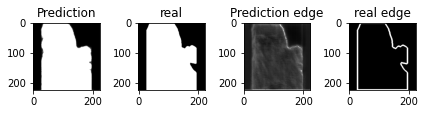

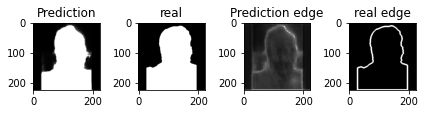

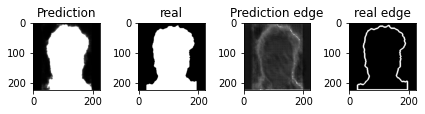

In [14]:
from matplotlib import pyplot as plt
def evaluate(dataLoader, netmodel):
    # switch to eval mode
    netmodel.eval()
    
    loss_Softmax = nn.CrossEntropyLoss(ignore_index=255) # mask loss
    loss_Focalloss = FocalLoss(gamma=2) # edge loss
    
    softmax = nn.Softmax(dim=1)
    iou = 0
    
    for i, (input_ori, input, edge, mask) in enumerate(dataLoader):
        if i == 10:
            break
        input_ori_var = Variable(input_ori.cuda())
        input_var = Variable(input.cuda())
        edge_var = Variable(edge.cuda())
        mask_var = Variable(mask.cuda())
        
        output_mask, output_edge = netmodel(input_var)
        
        prob = softmax(output_mask)[0,1,:,:]
        pred = prob.data.cpu().numpy()
        pred[pred>0.5] = 1

        prob = softmax(output_edge)[0,1,:,:]
        pred_edge = prob.data.cpu().numpy()
        pred_edge[pred_edge>0.5] = 1
    
        plt.figure(figsize=(6, 3))

        # Plot the first image on the left subplot
        plt.subplot(1, 4, 1)
        plt.imshow(pred, cmap="gray")
        plt.title('Prediction')

        # Plot the second image on the right subplot
        plt.subplot(1, 4, 2)
        plt.imshow(mask[0], cmap='gray')
        plt.title('real')

        plt.subplot(1, 4, 3)
        plt.imshow(pred_edge, cmap="gray")
        plt.title('Prediction edge')

        plt.subplot(1, 4, 4)
        plt.imshow(edge[0], cmap='gray')
        plt.title('real edge')

        # Adjust spacing between the subplots
        plt.tight_layout()

        # Show the plot
        plt.show()

evaluate(dataLoader_test, netmodel)